2024-06-10

Authors:
* Leandro SARAIVA MAIA
* Oscar BAUME
* Miguel JALUBE

This notebook uses the **LEANDRONE_V2** dataset https://huggingface.co/datasets/Leandro4002/LEANDRONE_V2

# 1. Prepare the labels

In [12]:
import csv
import random

L = []

# Load labels in a randomized order
with open('labels.csv') as f:
    labels = csv.reader(f, delimiter=';')
    for lines in labels:
        lines[1] = float(lines[1])
        L.append(lines)
random_idx = list(range(len(L)))
random.shuffle(random_idx)

print(L)

[['00_00.png', -0.04881754187845043], ['00_01.png', 0.04906715233908746], ['00_02.png', 0.08485470738964143], ['00_03.png', 0.08043066958386594], ['00_04.png', 0.06352413356759913], ['00_05.png', 0.05049954926391492], ['00_06.png', 0.4442886675220852], ['00_07.png', 0.7363350517455265], ['00_08.png', 1.429260818082055], ['00_09.png', 0.9812349534192034], ['00_10.png', 0.2692099147753931], ['00_11.png', 0.1326811918507119], ['00_12.png', 0.052133101605828305], ['00_13.png', 0.1310384433446586], ['00_14.png', 0.08786915671824624], ['00_15.png', 0.029349058904377813], ['00_16.png', 0.20110091217913728], ['00_17.png', 0.10869839218132472], ['00_18.png', 0.12238794354108545], ['00_19.png', -0.10067358206206009], ['00_20.png', 0.011685713690748454], ['00_21.png', 0.11662955693344412], ['00_22.png', 0.14512452498163533], ['00_23.png', 0.1915446142562426], ['00_24.png', 0.25536295089100325], ['00_25.png', 0.40009968697638115], ['00_26.png', 0.35227905285806804], ['00_27.png', 0.460621253612907

# 2. Prepare image dataset

In [13]:
import cv2
import torch

images = []

for i in random_idx:
    filename = f"render/{L[i][0]}"
    img = cv2.imread(filename)

    # Grayscale image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## Apply edge detection
    sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    img = cv2.magnitude(sobel_x, sobel_y)

    # 0-255 --> 0-1
    img = img / 255.0
    images.append(img)

tensor_images = torch.tensor(images, dtype=torch.float32)
tensor_images = tensor_images.unsqueeze(1)

# 3. Display some random samples

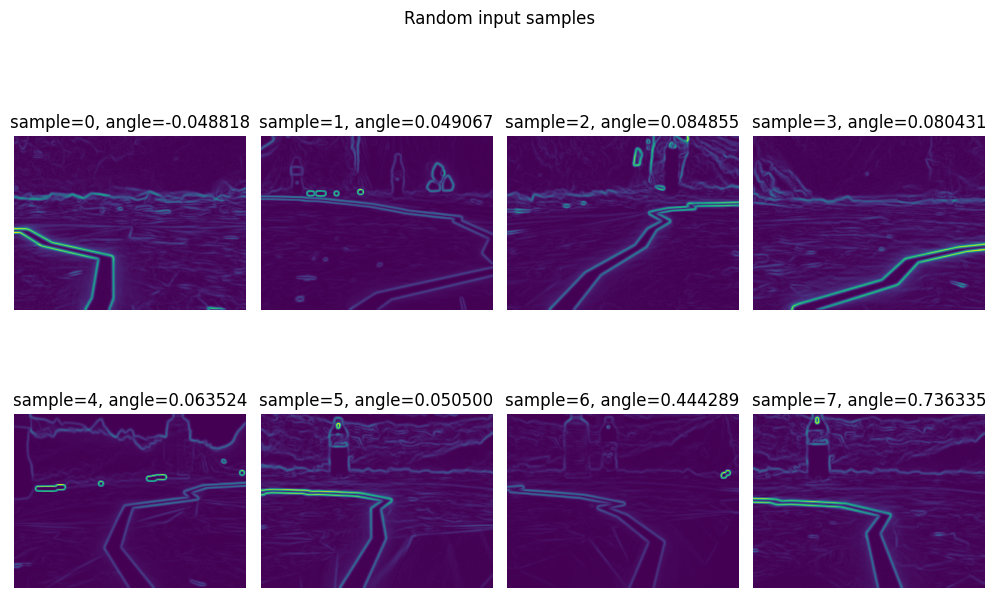

In [14]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 4
i = 0
plt.suptitle("Random input samples")
for random_index in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(images[random_index])
    plt.axis('off')
    plt.title('sample=%d, angle=%f' % (i, L[random_index][1]))
    i += 1
plt.tight_layout()

# 4. Create model layer topography

In [15]:
import torch
import torch.nn as nn
from angle_finder import AngleFinder

# Hyperparameters
learning_rate = 0.0001
num_epochs = 100

model = AngleFinder()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

print(model)

AngleFinder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=632448, out_features=1, bias=True)
)


# 5. Separate images into train and evaluation set

In [16]:
len_images = len(images)
images_idx = range(len_images)
middle_idx = int(len_images * 0.8)
train_idx = images_idx[0:middle_idx]
eval_idx = images_idx[middle_idx:]
tensor_train = tensor_images[0:middle_idx]
tensor_eval = tensor_images[middle_idx:]
print("     Train samples: %d" % len(train_idx))
print("Evaluation samples: %d" % len(eval_idx))
print("     Total samples: %d" % len_images)

     Train samples: 192
Evaluation samples: 48
     Total samples: 240


# 6. Train the model

<font style="color:red">CAREFUL! This node can take up to 5-10 minutes</font>

In [17]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

# Compute target values for training dataset
T_list = []
for j in range(middle_idx):
    target = [L[j][1]]
    target = torch.tensor(target)
    T_list.append(target)
T = torch.stack(T_list, dim=0)

losses = []
for i in range(num_epochs):
    # Predict
    Q = model(tensor_train)

    # Adjust weights
    optimizer.zero_grad()
    loss = criterion(T, Q)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

    # Plot loss on a graph
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].set_title("Loss")
    ax[0].plot(losses)
    ax[0].grid()
    ax[1].set_title("Loss (10 last epochs)")
    ax[1].plot(losses[-10:])
    ax[1].grid()
    fig.suptitle('epochs: %d / %d' % (i + 1, num_epochs))
    plt.tight_layout()
    plt.show()
    clear_output(wait=True)


# 7. Evalutate the model

In [18]:
import math

# Compute target values for evaluation dataset
T_list = []
for j in range(middle_idx, middle_idx + tensor_eval.shape[0]):
    target = [L[j][1]]
    target = torch.tensor(target)
    T_list.append(target)
T_eval = torch.stack(T_list, dim=0)

# Predict
Q_eval = model(tensor_eval)

# Adjust weights
loss = criterion(T_eval, Q_eval).item()

# Compute average pixel distance error when predicting points
#for i in range(Q_eval.shape[0]):
#    print(Q_eval[0])
#    print(T_eval[0])

print("Loss: %f" % loss)


Loss: 0.056590


# 8. Display some evaluations samples

/tmp/ipykernel_472911/3978797409.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('[%d] true=%.2f pred=%.2f' % (i, true_val, pred_val))


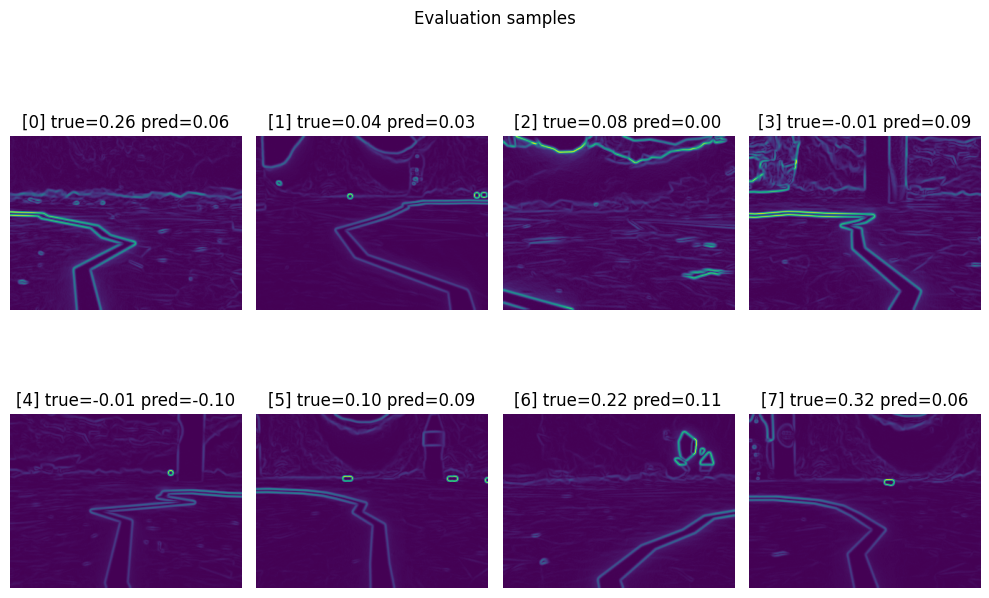

In [19]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 4
plt.suptitle("Evaluation samples")
i = 0
for index in range(middle_idx, middle_idx + rows*columns):
    true_val = T_eval[i].detach().numpy()

    pred = model(tensor_images[index:index+1])
    pred_val = pred.detach().numpy()[0]

    fig.add_subplot(rows, columns, i+1)
    plt.imshow(images[index])
    plt.axis('off')
    plt.title('[%d] true=%.2f pred=%.2f' % (i, true_val, pred_val))

    i += 1

plt.tight_layout()

# 9. Save the model to a file

In [20]:
torch.save(model.state_dict(), "followLineModel.pth")